# (08) Sim -- behavior of ```filter()``` when ```dim=65```

**Motivation**: Getting ready to generate and save. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

    
def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 80, 81) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['magenta', 'k', 'g', 'r'], [2, 4, 6, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

## Accept explore

In [3]:
from skimage.transform import resize

kws = dict(
    n=int(1e3),
    dim=65,
    fov=45.0,
    obj_r=0.2,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 5.0),
    vlim_slf=(0.01, 5.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 6

{
    'n': 1000,
    'dim': 65,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [4]:
combos = [
    ('fixate', 0), ('fixate', 1), ('fixate', 2), ('fixate', 4), ('fixate', 8),
    ('obj', 1), ('obj', 2), ('obj', 4), ('obj', 8),
    ('terrain', 4), ('terrain', 8), ('terrain', 16),
    ('transl', 0), ('transl', 2),
]

In [5]:
for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = OpticFlow(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    
    msg = f"category: {category}, # objects = {n_obj}    ||    "
    msg += f"accepted: {100 * accept.sum() / len(accept):0.1f}"
    msg += f" %,  (min obj size = {min_obj_size})"
    print(msg)

category: fixate, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 6)

category: fixate, # objects = 1    ||    accepted: 97.7 %,  (min obj size = 6)

category: fixate, # objects = 2    ||    accepted: 95.1 %,  (min obj size = 6)

category: fixate, # objects = 4    ||    accepted: 91.2 %,  (min obj size = 6)

category: fixate, # objects = 8    ||    accepted: 85.2 %,  (min obj size = 6)

category: obj, # objects = 1    ||    accepted: 97.7 %,  (min obj size = 6)

category: obj, # objects = 2    ||    accepted: 95.1 %,  (min obj size = 6)

category: obj, # objects = 4    ||    accepted: 91.2 %,  (min obj size = 6)

category: obj, # objects = 8    ||    accepted: 85.2 %,  (min obj size = 6)

category: terrain, # objects = 4    ||    accepted: 81.2 %,  (min obj size = 6)

category: terrain, # objects = 8    ||    accepted: 67.2 %,  (min obj size = 6)

category: terrain, # objects = 16    ||    accepted: 47.3 %,  (min obj size = 6)

category: transl, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 6)

category: transl, # objects = 2    ||    accepted: 95.1 %,  (min obj size = 6)

- Now change the ```min_n_obj``` to make it a bit relaxed. For instance, when ```n_obj > 2```, make it such that not all objects should be present (e.g., 7 out of 8 should suffice when ```n_obj=8```).

In [6]:
accept_n = {
    0: None,
    1: None,
    2: None,
    4: 3,
    8: 7,
    16: 14,
}

for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = OpticFlow(**kws).compute_coords()
    _ = of.compute_flow()

    min_n_obj = accept_n[n_obj]
    accept = of.filter(
        min_obj_size=min_obj_size,
        min_n_obj=min_n_obj,
    )

    msg = f"category: {category}, # objects = {n_obj}    ||    "
    msg += f"accepted: {100 * accept.sum() / len(accept):0.1f}"
    msg += f" %,  (min size = {min_obj_size}, min n = {min_n_obj})"
    print(msg)

category: fixate, # objects = 0    ||    accepted: 100.0 %,  (min size = 6, min n = None)

category: fixate, # objects = 1    ||    accepted: 97.7 %,  (min size = 6, min n = None)

category: fixate, # objects = 2    ||    accepted: 95.1 %,  (min size = 6, min n = None)

category: fixate, # objects = 4    ||    accepted: 99.5 %,  (min size = 6, min n = 3)

category: fixate, # objects = 8    ||    accepted: 97.6 %,  (min size = 6, min n = 7)

category: obj, # objects = 1    ||    accepted: 97.7 %,  (min size = 6, min n = None)

category: obj, # objects = 2    ||    accepted: 95.1 %,  (min size = 6, min n = None)

category: obj, # objects = 4    ||    accepted: 99.5 %,  (min size = 6, min n = 3)

category: obj, # objects = 8    ||    accepted: 97.6 %,  (min size = 6, min n = 7)

category: terrain, # objects = 4    ||    accepted: 98.2 %,  (min size = 6, min n = 3)

category: terrain, # objects = 8    ||    accepted: 92.2 %,  (min size = 6, min n = 7)

category: terrain, # objects = 16    ||    accepted: 92.1 %,  (min size = 6, min n = 14)

category: transl, # objects = 0    ||    accepted: 100.0 %,  (min size = 6, min n = None)

category: transl, # objects = 2    ||    accepted: 95.1 %,  (min size = 6, min n = None)

## category = ```terrain```, n_obj=16

In [7]:
kws['category'] = 'terrain'
kws['n_obj'] = 16
of = OpticFlow(**kws).compute_coords()
_ = of.compute_flow()

In [8]:
min_obj_size = 6

accepted = [
    obj.size > min_obj_size / of.dim**2
    for obj in of.objects.values()
]
num_present = np.stack(accepted).sum(0)

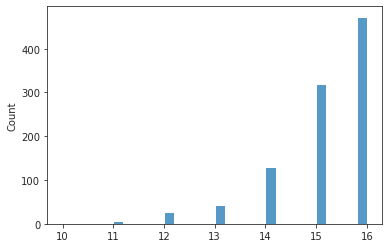

In [9]:
sns.histplot(num_present);

In [10]:
for min_n in [16, 15, 14, 13]:
    print(f"min n = {min_n},\taccepted: {100 * (num_present >= min_n).sum() / of.n:0.1f} %")

min n = 16,     accepted: 47.3 %

min n = 15,     accepted: 79.2 %

min n = 14,     accepted: 92.1 %

min n = 13,     accepted: 96.4 %